In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

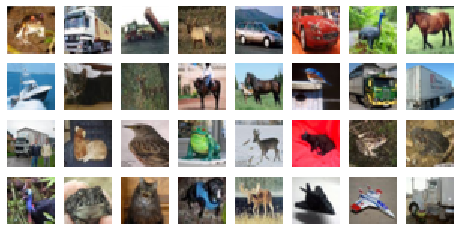

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

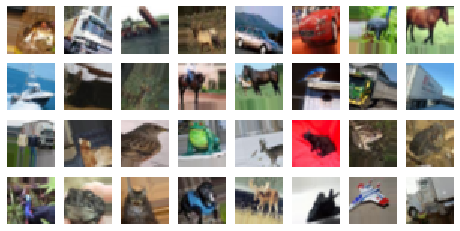

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

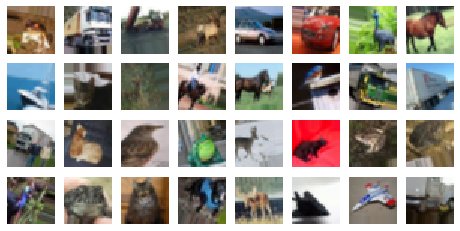

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [8]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os
import numpy as np

In [9]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

(x_train, y_train), (x_test,y_test)=cifar10.load_data()

#y_label進行one-hot encode
y_train= keras.utils.to_categorical(y_train, num_classes)
y_test= keras.utils.to_categorical(y_test, num_classes)

In [10]:
#進行 image_augmentation
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

x_train_aug=next(data_generator.flow(x_train,batch_size=1000,shuffle=False))
x_test_aug=next(data_generator.flow(x_test,shuffle=False))

print(x_train.shape)
print(x_train_aug.shape)

(50000, 32, 32, 3)
(1000, 32, 32, 3)


In [12]:
#將資料轉換為float32
x_train_nor=x_train.astype('float32')
x_test_nor=x_test.astype('float32')
x_test_aug_nor=x_test_aug.astype('float32')
x_train_aug_nor=x_train_aug.astype('float32')


#將資料進行標準化（divid 255）
x_train_nor /= 255
x_test_nor /= 255
x_test_aug_nor /= 255
x_train_aug_nor /=255
print(x_train_nor.shape)
print(x_test_nor.shape)
print(x_train_aug_nor.shape)
print(x_test_aug_nor.shape)

x_train_01=np.concatenate([x_train_nor,x_train_aug_nor])
y_train_01=np.concatenate([y_train,y_train[:1000]])
print(x_train_01.shape)
print(y_train_01.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(1000, 32, 32, 3)
(32, 32, 32, 3)
(51000, 32, 32, 3)
(51000, 10)


In [13]:
model= Sequential()
model.add(Conv2D(32,(3,3),padding='same',
                input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train_01, y_train_01,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 51000 samples, validate on 10000 samples
Epoch 1/10
51000/51000 [==============================] - 57s 1ms/step - loss: 1.8484 - accuracy: 0.3176 - val_loss: 117.5595 - val_accuracy: 0.4672
Epoch 2/10
51000/51000 [==============================] - 55s 1ms/step - loss: 1.4191 - accuracy: 0.4941 - val_loss: 133.8645 - val_accuracy: 0.4417
Epoch 3/10
51000/51000 [==============================] - 60s 1ms/step - loss: 1.2457 - accuracy: 0.5662 - val_loss: 148.1214 - val_accuracy: 0.4737
Epoch 4/10
51000/51000 [==============================] - 62s 1ms/step - loss: 1.1265 - accuracy: 0.6128 - val_loss: 120.9170 - val_accuracy: 0.5098
Epoch 5/10
51000/51000 [==============================] - 55s 1ms/step - loss: 1.0428 - accuracy: 0.6477 - val_loss: 114.3729 - val_accuracy: 0.5785
Epoch 6/10
51000/51000 [==============================] - 55s 1ms/step - loss: 0.9725 - accuracy: 0.6741 - val_loss: 184.2593 - val_accuracy: 0.5232
Epoch 7/10
51000/51000 [==============================] 

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 54s 1ms/step - loss: 7.2115 - accuracy: 0.4192 - val_loss: 2.1910 - val_accuracy: 0.1520
Epoch 2/10
50000/50000 [==============================] - 54s 1ms/step - loss: 2.2005 - accuracy: 0.2852 - val_loss: 2.2381 - val_accuracy: 0.1393
Epoch 3/10
50000/50000 [==============================] - 54s 1ms/step - loss: 2.2920 - accuracy: 0.2188 - val_loss: 2.0776 - val_accuracy: 0.2082
Epoch 4/10
50000/50000 [==============================] - 58s 1ms/step - loss: 2.2764 - accuracy: 0.1896 - val_loss: 2.1302 - val_accuracy: 0.1813
Epoch 5/10
50000/50000 [==============================] - 59s 1ms/step - loss: 2.2073 - accuracy: 0.1995 - val_loss: 1.9545 - val_accuracy: 0.2405
Epoch 6/10
50000/50000 [==============================] - 61s 1ms/step - loss: 2.1406 - accuracy: 0.2071 - val_loss: 1.8813 - val_accuracy: 0.2655
Epoch 7/10
50000/50000 [==============================] - 56s 1ms/st